In [11]:
#!pip install git+https://github.com/nerfstudio-project/gsplat.git

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import torch
from PIL import Image
from gsplat.rendering import rasterization
import math
import matplotlib.pyplot as plt
from diffusers import EulerAncestralDiscreteScheduler
from einops import rearrange

device = 'cuda'

In [14]:
# Copyright 2024 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import inspect
from typing import Any, Callable, Dict, List, Optional, Union

import numpy as np
import PIL.Image
import torch
from packaging import version
from transformers import CLIPImageProcessor, CLIPTextModel, CLIPTokenizer, CLIPVisionModelWithProjection

from diffusers.callbacks import MultiPipelineCallbacks, PipelineCallback
from diffusers.configuration_utils import FrozenDict
from diffusers.image_processor import PipelineImageInput, VaeImageProcessor
from diffusers.loaders import FromSingleFileMixin, IPAdapterMixin, LoraLoaderMixin, TextualInversionLoaderMixin
from diffusers.models import AutoencoderKL, ImageProjection, UNet2DConditionModel
from diffusers.models.lora import adjust_lora_scale_text_encoder
from diffusers.schedulers import KarrasDiffusionSchedulers
from diffusers.utils import (
    PIL_INTERPOLATION,
    USE_PEFT_BACKEND,
    deprecate,
    logging,
    replace_example_docstring,
    scale_lora_layers,
    unscale_lora_layers,
)
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.pipeline_utils import DiffusionPipeline, StableDiffusionMixin
from diffusers.pipelines.stable_diffusion.pipeline_output import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker


logger = logging.get_logger(__name__)  # pylint: disable=invalid-name

EXAMPLE_DOC_STRING = """
    Examples:
        ```py
        >>> import requests
        >>> import torch
        >>> from PIL import Image
        >>> from io import BytesIO

        >>> from diffusers import StableDiffusionImg2ImgPipeline

        >>> device = "cuda"
        >>> model_id_or_path = "runwayml/stable-diffusion-v1-5"
        >>> pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
        >>> pipe = pipe.to(device)

        >>> url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

        >>> response = requests.get(url)
        >>> init_image = Image.open(BytesIO(response.content)).convert("RGB")
        >>> init_image = init_image.resize((768, 512))

        >>> prompt = "A fantasy landscape, trending on artstation"

        >>> images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images
        >>> images[0].save("fantasy_landscape.png")
        ```
"""


def retrieve_latents(
    encoder_output: torch.Tensor, generator: Optional[torch.Generator] = None, sample_mode: str = "sample"
):
    if hasattr(encoder_output, "latent_dist") and sample_mode == "sample":
        return encoder_output.latent_dist.sample(generator)
    elif hasattr(encoder_output, "latent_dist") and sample_mode == "argmax":
        return encoder_output.latent_dist.mode()
    elif hasattr(encoder_output, "latents"):
        return encoder_output.latents
    else:
        raise AttributeError("Could not access latents of provided encoder_output")


def preprocess(image):
    deprecation_message = "The preprocess method is deprecated and will be removed in diffusers 1.0.0. Please use VaeImageProcessor.preprocess(...) instead"
    deprecate("preprocess", "1.0.0", deprecation_message, standard_warn=False)
    if isinstance(image, torch.Tensor):
        return image
    elif isinstance(image, PIL.Image.Image):
        image = [image]

    if isinstance(image[0], PIL.Image.Image):
        w, h = image[0].size
        w, h = (x - x % 8 for x in (w, h))  # resize to integer multiple of 8

        image = [np.array(i.resize((w, h), resample=PIL_INTERPOLATION["lanczos"]))[None, :] for i in image]
        image = np.concatenate(image, axis=0)
        image = np.array(image).astype(np.float32) / 255.0
        image = image.transpose(0, 3, 1, 2)
        image = 2.0 * image - 1.0
        image = torch.from_numpy(image)
    elif isinstance(image[0], torch.Tensor):
        image = torch.cat(image, dim=0)
    return image


# Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.retrieve_timesteps
def retrieve_timesteps(
    scheduler,
    num_inference_steps: Optional[int] = None,
    device: Optional[Union[str, torch.device]] = None,
    timesteps: Optional[List[int]] = None,
    sigmas: Optional[List[float]] = None,
    **kwargs,
):
    """
    Calls the scheduler's `set_timesteps` method and retrieves timesteps from the scheduler after the call. Handles
    custom timesteps. Any kwargs will be supplied to `scheduler.set_timesteps`.

    Args:
        scheduler (`SchedulerMixin`):
            The scheduler to get timesteps from.
        num_inference_steps (`int`):
            The number of diffusion steps used when generating samples with a pre-trained model. If used, `timesteps`
            must be `None`.
        device (`str` or `torch.device`, *optional*):
            The device to which the timesteps should be moved to. If `None`, the timesteps are not moved.
        timesteps (`List[int]`, *optional*):
            Custom timesteps used to override the timestep spacing strategy of the scheduler. If `timesteps` is passed,
            `num_inference_steps` and `sigmas` must be `None`.
        sigmas (`List[float]`, *optional*):
            Custom sigmas used to override the timestep spacing strategy of the scheduler. If `sigmas` is passed,
            `num_inference_steps` and `timesteps` must be `None`.

    Returns:
        `Tuple[torch.Tensor, int]`: A tuple where the first element is the timestep schedule from the scheduler and the
        second element is the number of inference steps.
    """
    if timesteps is not None and sigmas is not None:
        raise ValueError("Only one of `timesteps` or `sigmas` can be passed. Please choose one to set custom values")
    if timesteps is not None:
        accepts_timesteps = "timesteps" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accepts_timesteps:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" timestep schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(timesteps=timesteps, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    elif sigmas is not None:
        accept_sigmas = "sigmas" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accept_sigmas:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" sigmas schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(sigmas=sigmas, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    else:
        scheduler.set_timesteps(num_inference_steps, device=device, **kwargs)
        timesteps = scheduler.timesteps
    return timesteps, num_inference_steps


class StableDiffusionImg2ImgPipeline(
    DiffusionPipeline,
    StableDiffusionMixin,
    TextualInversionLoaderMixin,
    IPAdapterMixin,
    LoraLoaderMixin,
    FromSingleFileMixin,
):
    r"""
    Pipeline for text-guided image-to-image generation using Stable Diffusion.

    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods
    implemented for all pipelines (downloading, saving, running on a particular device, etc.).

    The pipeline also inherits the following loading methods:
        - [`~loaders.TextualInversionLoaderMixin.load_textual_inversion`] for loading textual inversion embeddings
        - [`~loaders.LoraLoaderMixin.load_lora_weights`] for loading LoRA weights
        - [`~loaders.LoraLoaderMixin.save_lora_weights`] for saving LoRA weights
        - [`~loaders.FromSingleFileMixin.from_single_file`] for loading `.ckpt` files
        - [`~loaders.IPAdapterMixin.load_ip_adapter`] for loading IP Adapters

    Args:
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) model to encode and decode images to and from latent representations.
        text_encoder ([`~transformers.CLIPTextModel`]):
            Frozen text-encoder ([clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14)).
        tokenizer ([`~transformers.CLIPTokenizer`]):
            A `CLIPTokenizer` to tokenize text.
        unet ([`UNet2DConditionModel`]):
            A `UNet2DConditionModel` to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latents. Can be one of
            [`DDIMScheduler`], [`LMSDiscreteScheduler`], or [`PNDMScheduler`].
        safety_checker ([`StableDiffusionSafetyChecker`]):
            Classification module that estimates whether generated images could be considered offensive or harmful.
            Please refer to the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5) for more details
            about a model's potential harms.
        feature_extractor ([`~transformers.CLIPImageProcessor`]):
            A `CLIPImageProcessor` to extract features from generated images; used as inputs to the `safety_checker`.
    """

    model_cpu_offload_seq = "text_encoder->image_encoder->unet->vae"
    _optional_components = ["safety_checker", "feature_extractor", "image_encoder"]
    _exclude_from_cpu_offload = ["safety_checker"]
    _callback_tensor_inputs = ["latents", "prompt_embeds", "negative_prompt_embeds"]

    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: KarrasDiffusionSchedulers,
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPImageProcessor,
        image_encoder: CLIPVisionModelWithProjection = None,
        requires_safety_checker: bool = True,
    ):
        super().__init__()

        if hasattr(scheduler.config, "steps_offset") and scheduler.config.steps_offset != 1:
            deprecation_message = (
                f"The configuration file of this scheduler: {scheduler} is outdated. `steps_offset`"
                f" should be set to 1 instead of {scheduler.config.steps_offset}. Please make sure "
                "to update the config accordingly as leaving `steps_offset` might led to incorrect results"
                " in future versions. If you have downloaded this checkpoint from the Hugging Face Hub,"
                " it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json`"
                " file"
            )
            deprecate("steps_offset!=1", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(scheduler.config)
            new_config["steps_offset"] = 1
            scheduler._internal_dict = FrozenDict(new_config)

        if hasattr(scheduler.config, "clip_sample") and scheduler.config.clip_sample is True:
            deprecation_message = (
                f"The configuration file of this scheduler: {scheduler} has not set the configuration `clip_sample`."
                " `clip_sample` should be set to False in the configuration file. Please make sure to update the"
                " config accordingly as not setting `clip_sample` in the config might lead to incorrect results in"
                " future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very"
                " nice if you could open a Pull request for the `scheduler/scheduler_config.json` file"
            )
            deprecate("clip_sample not set", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(scheduler.config)
            new_config["clip_sample"] = False
            scheduler._internal_dict = FrozenDict(new_config)

        if safety_checker is None and requires_safety_checker:
            logger.warning(
                f"You have disabled the safety checker for {self.__class__} by passing `safety_checker=None`. Ensure"
                " that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered"
                " results in services or applications open to the public. Both the diffusers team and Hugging Face"
                " strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling"
                " it only for use-cases that involve analyzing network behavior or auditing its results. For more"
                " information, please have a look at https://github.com/huggingface/diffusers/pull/254 ."
            )

        if safety_checker is not None and feature_extractor is None:
            raise ValueError(
                "Make sure to define a feature extractor when loading {self.__class__} if you want to use the safety"
                " checker. If you do not want to use the safety checker, you can pass `'safety_checker=None'` instead."
            )

        is_unet_version_less_0_9_0 = hasattr(unet.config, "_diffusers_version") and version.parse(
            version.parse(unet.config._diffusers_version).base_version
        ) < version.parse("0.9.0.dev0")
        is_unet_sample_size_less_64 = hasattr(unet.config, "sample_size") and unet.config.sample_size < 64
        if is_unet_version_less_0_9_0 and is_unet_sample_size_less_64:
            deprecation_message = (
                "The configuration file of the unet has set the default `sample_size` to smaller than"
                " 64 which seems highly unlikely. If your checkpoint is a fine-tuned version of any of the"
                " following: \n- CompVis/stable-diffusion-v1-4 \n- CompVis/stable-diffusion-v1-3 \n-"
                " CompVis/stable-diffusion-v1-2 \n- CompVis/stable-diffusion-v1-1 \n- runwayml/stable-diffusion-v1-5"
                " \n- runwayml/stable-diffusion-inpainting \n you should change 'sample_size' to 64 in the"
                " configuration file. Please make sure to update the config accordingly as leaving `sample_size=32`"
                " in the config might lead to incorrect results in future versions. If you have downloaded this"
                " checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for"
                " the `unet/config.json` file"
            )
            deprecate("sample_size<64", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(unet.config)
            new_config["sample_size"] = 64
            unet._internal_dict = FrozenDict(new_config)

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
            image_encoder=image_encoder,
        )
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1)
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor)
        self.register_to_config(requires_safety_checker=requires_safety_checker)

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline._encode_prompt
    def _encode_prompt(
        self,
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt=None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        lora_scale: Optional[float] = None,
        **kwargs,
    ):
        deprecation_message = "`_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple."
        deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)

        prompt_embeds_tuple = self.encode_prompt(
            prompt=prompt,
            device=device,
            num_images_per_prompt=num_images_per_prompt,
            do_classifier_free_guidance=do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=lora_scale,
            **kwargs,
        )

        # concatenate for backwards comp
        prompt_embeds = torch.cat([prompt_embeds_tuple[1], prompt_embeds_tuple[0]])

        return prompt_embeds

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.encode_prompt
    def encode_prompt(
        self,
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt=None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        lora_scale: Optional[float] = None,
        clip_skip: Optional[int] = None,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            device: (`torch.device`):
                torch device
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            do_classifier_free_guidance (`bool`):
                whether to use classifier free guidance or not
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
            lora_scale (`float`, *optional*):
                A LoRA scale that will be applied to all LoRA layers of the text encoder if LoRA layers are loaded.
            clip_skip (`int`, *optional*):
                Number of layers to be skipped from CLIP while computing the prompt embeddings. A value of 1 means that
                the output of the pre-final layer will be used for computing the prompt embeddings.
        """
        # set lora scale so that monkey patched LoRA
        # function of text encoder can correctly access it
        if lora_scale is not None and isinstance(self, LoraLoaderMixin):
            self._lora_scale = lora_scale

            # dynamically adjust the LoRA scale
            if not USE_PEFT_BACKEND:
                adjust_lora_scale_text_encoder(self.text_encoder, lora_scale)
            else:
                scale_lora_layers(self.text_encoder, lora_scale)

        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        if prompt_embeds is None:
            # textual inversion: process multi-vector tokens if necessary
            if isinstance(self, TextualInversionLoaderMixin):
                prompt = self.maybe_convert_prompt(prompt, self.tokenizer)

            text_inputs = self.tokenizer(
                prompt,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids = self.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                text_input_ids, untruncated_ids
            ):
                removed_text = self.tokenizer.batch_decode(
                    untruncated_ids[:, self.tokenizer.model_max_length - 1 : -1]
                )
                logger.warning(
                    "The following part of your input was truncated because CLIP can only handle sequences up to"
                    f" {self.tokenizer.model_max_length} tokens: {removed_text}"
                )

            if hasattr(self.text_encoder.config, "use_attention_mask") and self.text_encoder.config.use_attention_mask:
                attention_mask = text_inputs.attention_mask.to(device)
            else:
                attention_mask = None

            if clip_skip is None:
                prompt_embeds = self.text_encoder(text_input_ids.to(device), attention_mask=attention_mask)
                prompt_embeds = prompt_embeds[0]
            else:
                prompt_embeds = self.text_encoder(
                    text_input_ids.to(device), attention_mask=attention_mask, output_hidden_states=True
                )
                # Access the `hidden_states` first, that contains a tuple of
                # all the hidden states from the encoder layers. Then index into
                # the tuple to access the hidden states from the desired layer.
                prompt_embeds = prompt_embeds[-1][-(clip_skip + 1)]
                # We also need to apply the final LayerNorm here to not mess with the
                # representations. The `last_hidden_states` that we typically use for
                # obtaining the final prompt representations passes through the LayerNorm
                # layer.
                prompt_embeds = self.text_encoder.text_model.final_layer_norm(prompt_embeds)

        if self.text_encoder is not None:
            prompt_embeds_dtype = self.text_encoder.dtype
        elif self.unet is not None:
            prompt_embeds_dtype = self.unet.dtype
        else:
            prompt_embeds_dtype = prompt_embeds.dtype

        prompt_embeds = prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance and negative_prompt_embeds is None:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif prompt is not None and type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            # textual inversion: process multi-vector tokens if necessary
            if isinstance(self, TextualInversionLoaderMixin):
                uncond_tokens = self.maybe_convert_prompt(uncond_tokens, self.tokenizer)

            max_length = prompt_embeds.shape[1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )

            if hasattr(self.text_encoder.config, "use_attention_mask") and self.text_encoder.config.use_attention_mask:
                attention_mask = uncond_input.attention_mask.to(device)
            else:
                attention_mask = None

            negative_prompt_embeds = self.text_encoder(
                uncond_input.input_ids.to(device),
                attention_mask=attention_mask,
            )
            negative_prompt_embeds = negative_prompt_embeds[0]

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]

            negative_prompt_embeds = negative_prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

        if self.text_encoder is not None:
            if isinstance(self, LoraLoaderMixin) and USE_PEFT_BACKEND:
                # Retrieve the original scale by scaling back the LoRA layers
                unscale_lora_layers(self.text_encoder, lora_scale)

        return prompt_embeds, negative_prompt_embeds

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.encode_image
    def encode_image(self, image, device, num_images_per_prompt, output_hidden_states=None):
        dtype = next(self.image_encoder.parameters()).dtype

        if not isinstance(image, torch.Tensor):
            image = self.feature_extractor(image, return_tensors="pt").pixel_values

        image = image.to(device=device, dtype=dtype)
        if output_hidden_states:
            image_enc_hidden_states = self.image_encoder(image, output_hidden_states=True).hidden_states[-2]
            image_enc_hidden_states = image_enc_hidden_states.repeat_interleave(num_images_per_prompt, dim=0)
            uncond_image_enc_hidden_states = self.image_encoder(
                torch.zeros_like(image), output_hidden_states=True
            ).hidden_states[-2]
            uncond_image_enc_hidden_states = uncond_image_enc_hidden_states.repeat_interleave(
                num_images_per_prompt, dim=0
            )
            return image_enc_hidden_states, uncond_image_enc_hidden_states
        else:
            image_embeds = self.image_encoder(image).image_embeds
            image_embeds = image_embeds.repeat_interleave(num_images_per_prompt, dim=0)
            uncond_image_embeds = torch.zeros_like(image_embeds)

            return image_embeds, uncond_image_embeds

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.prepare_ip_adapter_image_embeds
    def prepare_ip_adapter_image_embeds(
        self, ip_adapter_image, ip_adapter_image_embeds, device, num_images_per_prompt, do_classifier_free_guidance
    ):
        if ip_adapter_image_embeds is None:
            if not isinstance(ip_adapter_image, list):
                ip_adapter_image = [ip_adapter_image]

            if len(ip_adapter_image) != len(self.unet.encoder_hid_proj.image_projection_layers):
                raise ValueError(
                    f"`ip_adapter_image` must have same length as the number of IP Adapters. Got {len(ip_adapter_image)} images and {len(self.unet.encoder_hid_proj.image_projection_layers)} IP Adapters."
                )

            image_embeds = []
            for single_ip_adapter_image, image_proj_layer in zip(
                ip_adapter_image, self.unet.encoder_hid_proj.image_projection_layers
            ):
                output_hidden_state = not isinstance(image_proj_layer, ImageProjection)
                single_image_embeds, single_negative_image_embeds = self.encode_image(
                    single_ip_adapter_image, device, 1, output_hidden_state
                )
                single_image_embeds = torch.stack([single_image_embeds] * num_images_per_prompt, dim=0)
                single_negative_image_embeds = torch.stack(
                    [single_negative_image_embeds] * num_images_per_prompt, dim=0
                )

                if do_classifier_free_guidance:
                    single_image_embeds = torch.cat([single_negative_image_embeds, single_image_embeds])
                    single_image_embeds = single_image_embeds.to(device)

                image_embeds.append(single_image_embeds)
        else:
            repeat_dims = [1]
            image_embeds = []
            for single_image_embeds in ip_adapter_image_embeds:
                if do_classifier_free_guidance:
                    single_negative_image_embeds, single_image_embeds = single_image_embeds.chunk(2)
                    single_image_embeds = single_image_embeds.repeat(
                        num_images_per_prompt, *(repeat_dims * len(single_image_embeds.shape[1:]))
                    )
                    single_negative_image_embeds = single_negative_image_embeds.repeat(
                        num_images_per_prompt, *(repeat_dims * len(single_negative_image_embeds.shape[1:]))
                    )
                    single_image_embeds = torch.cat([single_negative_image_embeds, single_image_embeds])
                else:
                    single_image_embeds = single_image_embeds.repeat(
                        num_images_per_prompt, *(repeat_dims * len(single_image_embeds.shape[1:]))
                    )
                image_embeds.append(single_image_embeds)

        return image_embeds

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.run_safety_checker
    def run_safety_checker(self, image, device, dtype):
        return image, None

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.decode_latents
    def decode_latents(self, latents):
        deprecation_message = "The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead"
        deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)

        latents = 1 / self.vae.config.scaling_factor * latents
        image = self.vae.decode(latents, return_dict=False)[0]
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        return image

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.prepare_extra_step_kwargs
    def prepare_extra_step_kwargs(self, generator, eta):
        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]

        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        # check if the scheduler accepts generator
        accepts_generator = "generator" in set(inspect.signature(self.scheduler.step).parameters.keys())
        if accepts_generator:
            extra_step_kwargs["generator"] = generator
        return extra_step_kwargs

    def check_inputs(
        self,
        prompt,
        strength,
        callback_steps,
        negative_prompt=None,
        prompt_embeds=None,
        negative_prompt_embeds=None,
        ip_adapter_image=None,
        ip_adapter_image_embeds=None,
        callback_on_step_end_tensor_inputs=None,
    ):
        if strength < 0 or strength > 1:
            raise ValueError(f"The value of strength should in [0.0, 1.0] but is {strength}")

        if callback_steps is not None and (not isinstance(callback_steps, int) or callback_steps <= 0):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

        if callback_on_step_end_tensor_inputs is not None and not all(
            k in self._callback_tensor_inputs for k in callback_on_step_end_tensor_inputs
        ):
            raise ValueError(
                f"`callback_on_step_end_tensor_inputs` has to be in {self._callback_tensor_inputs}, but found {[k for k in callback_on_step_end_tensor_inputs if k not in self._callback_tensor_inputs]}"
            )
        if prompt is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt`: {prompt} and `prompt_embeds`: {prompt_embeds}. Please make sure to"
                " only forward one of the two."
            )
        elif prompt is None and prompt_embeds is None:
            raise ValueError(
                "Provide either `prompt` or `prompt_embeds`. Cannot leave both `prompt` and `prompt_embeds` undefined."
            )
        elif prompt is not None and (not isinstance(prompt, str) and not isinstance(prompt, list)):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if negative_prompt is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt`: {negative_prompt} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two."
            )

        if prompt_embeds is not None and negative_prompt_embeds is not None:
            if prompt_embeds.shape != negative_prompt_embeds.shape:
                raise ValueError(
                    "`prompt_embeds` and `negative_prompt_embeds` must have the same shape when passed directly, but"
                    f" got: `prompt_embeds` {prompt_embeds.shape} != `negative_prompt_embeds`"
                    f" {negative_prompt_embeds.shape}."
                )

        if ip_adapter_image is not None and ip_adapter_image_embeds is not None:
            raise ValueError(
                "Provide either `ip_adapter_image` or `ip_adapter_image_embeds`. Cannot leave both `ip_adapter_image` and `ip_adapter_image_embeds` defined."
            )

        if ip_adapter_image_embeds is not None:
            if not isinstance(ip_adapter_image_embeds, list):
                raise ValueError(
                    f"`ip_adapter_image_embeds` has to be of type `list` but is {type(ip_adapter_image_embeds)}"
                )
            elif ip_adapter_image_embeds[0].ndim not in [3, 4]:
                raise ValueError(
                    f"`ip_adapter_image_embeds` has to be a list of 3D or 4D tensors but is {ip_adapter_image_embeds[0].ndim}D"
                )

    def get_timesteps(self, num_inference_steps, strength, device):
        # get the original timestep using init_timestep
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

        t_start = max(num_inference_steps - init_timestep, 0)
        timesteps = self.scheduler.timesteps[t_start * self.scheduler.order :]
        if hasattr(self.scheduler, "set_begin_index"):
            self.scheduler.set_begin_index(t_start * self.scheduler.order)

        return timesteps, num_inference_steps - t_start

    def prepare_latents(self, image, timestep, batch_size, num_images_per_prompt, dtype, device, generator=None):
        if not isinstance(image, (torch.Tensor, PIL.Image.Image, list)):
            raise ValueError(
                f"`image` has to be of type `torch.Tensor`, `PIL.Image.Image` or list but is {type(image)}"
            )

        image = image.to(device=device, dtype=dtype)

        batch_size = batch_size * num_images_per_prompt

        if image.shape[1] == 4:
            init_latents = image

        else:
            if isinstance(generator, list) and len(generator) != batch_size:
                raise ValueError(
                    f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                    f" size of {batch_size}. Make sure the batch size matches the length of the generators."
                )

            elif isinstance(generator, list):
                init_latents = [
                    retrieve_latents(self.vae.encode(image[i : i + 1]), generator=generator[i])
                    for i in range(batch_size)
                ]
                init_latents = torch.cat(init_latents, dim=0)
            else:
                init_latents = retrieve_latents(self.vae.encode(image), generator=generator)

            init_latents = self.vae.config.scaling_factor * init_latents

        if batch_size > init_latents.shape[0] and batch_size % init_latents.shape[0] == 0:
            # expand init_latents for batch_size
            deprecation_message = (
                f"You have passed {batch_size} text prompts (`prompt`), but only {init_latents.shape[0]} initial"
                " images (`image`). Initial images are now duplicating to match the number of text prompts. Note"
                " that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update"
                " your script to pass as many initial images as text prompts to suppress this warning."
            )
            deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)
            additional_image_per_prompt = batch_size // init_latents.shape[0]
            init_latents = torch.cat([init_latents] * additional_image_per_prompt, dim=0)
        elif batch_size > init_latents.shape[0] and batch_size % init_latents.shape[0] != 0:
            raise ValueError(
                f"Cannot duplicate `image` of batch size {init_latents.shape[0]} to {batch_size} text prompts."
            )
        else:
            init_latents = torch.cat([init_latents], dim=0)

        shape = init_latents.shape
        noise = randn_tensor(shape, generator=generator, device=device, dtype=dtype)

        # get latents
        init_latents = self.scheduler.add_noise(init_latents, noise, timestep)
        latents = init_latents

        return latents

    # Copied from diffusers.pipelines.latent_consistency_models.pipeline_latent_consistency_text2img.LatentConsistencyModelPipeline.get_guidance_scale_embedding
    def get_guidance_scale_embedding(
        self, w: torch.Tensor, embedding_dim: int = 512, dtype: torch.dtype = torch.float32
    ) -> torch.Tensor:
        """
        See https://github.com/google-research/vdm/blob/dc27b98a554f65cdc654b800da5aa1846545d41b/model_vdm.py#L298

        Args:
            w (`torch.Tensor`):
                Generate embedding vectors with a specified guidance scale to subsequently enrich timestep embeddings.
            embedding_dim (`int`, *optional*, defaults to 512):
                Dimension of the embeddings to generate.
            dtype (`torch.dtype`, *optional*, defaults to `torch.float32`):
                Data type of the generated embeddings.

        Returns:
            `torch.Tensor`: Embedding vectors with shape `(len(w), embedding_dim)`.
        """
        assert len(w.shape) == 1
        w = w * 1000.0

        half_dim = embedding_dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=dtype) * -emb)
        emb = w.to(dtype)[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if embedding_dim % 2 == 1:  # zero pad
            emb = torch.nn.functional.pad(emb, (0, 1))
        assert emb.shape == (w.shape[0], embedding_dim)
        return emb

    @property
    def guidance_scale(self):
        return self._guidance_scale

    @property
    def clip_skip(self):
        return self._clip_skip

    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    @property
    def do_classifier_free_guidance(self):
        return self._guidance_scale > 1 and self.unet.config.time_cond_proj_dim is None

    @property
    def cross_attention_kwargs(self):
        return self._cross_attention_kwargs

    @property
    def num_timesteps(self):
        return self._num_timesteps

    @property
    def interrupt(self):
        return self._interrupt

    @torch.no_grad()
    @replace_example_docstring(EXAMPLE_DOC_STRING)
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        image: PipelineImageInput = None,
        strength: float = 0.8,
        num_inference_steps: Optional[int] = 50,
        timesteps: List[int] = None,
        sigmas: List[float] = None,
        guidance_scale: Optional[float] = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: Optional[float] = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        ip_adapter_image: Optional[PipelineImageInput] = None,
        ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        clip_skip: int = None,
        callback_on_step_end: Optional[
            Union[Callable[[int, int, Dict], None], PipelineCallback, MultiPipelineCallbacks]
        ] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
        **kwargs,
    ):
        r"""
        The call function to the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide image generation. If not defined, you need to pass `prompt_embeds`.
            image (`torch.Tensor`, `PIL.Image.Image`, `np.ndarray`, `List[torch.Tensor]`, `List[PIL.Image.Image]`, or `List[np.ndarray]`):
                `Image`, numpy array or tensor representing an image batch to be used as the starting point. For both
                numpy array and pytorch tensor, the expected value range is between `[0, 1]` If it's a tensor or a list
                or tensors, the expected shape should be `(B, C, H, W)` or `(C, H, W)`. If it is a numpy array or a
                list of arrays, the expected shape should be `(B, H, W, C)` or `(H, W, C)` It can also accept image
                latents as `image`, but if passing latents directly it is not encoded again.
            strength (`float`, *optional*, defaults to 0.8):
                Indicates extent to transform the reference `image`. Must be between 0 and 1. `image` is used as a
                starting point and more noise is added the higher the `strength`. The number of denoising steps depends
                on the amount of noise initially added. When `strength` is 1, added noise is maximum and the denoising
                process runs for the full number of iterations specified in `num_inference_steps`. A value of 1
                essentially ignores `image`.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference. This parameter is modulated by `strength`.
            timesteps (`List[int]`, *optional*):
                Custom timesteps to use for the denoising process with schedulers which support a `timesteps` argument
                in their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is
                passed will be used. Must be in descending order.
            sigmas (`List[float]`, *optional*):
                Custom sigmas to use for the denoising process with schedulers which support a `sigmas` argument in
                their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is passed
                will be used.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                A higher guidance scale value encourages the model to generate images closely linked to the text
                `prompt` at the expense of lower image quality. Guidance scale is enabled when `guidance_scale > 1`.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide what to not include in image generation. If not defined, you need to
                pass `negative_prompt_embeds` instead. Ignored when not using guidance (`guidance_scale < 1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) from the [DDIM](https://arxiv.org/abs/2010.02502) paper. Only applies
                to the [`~schedulers.DDIMScheduler`], and is ignored in other schedulers.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                A [`torch.Generator`](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make
                generation deterministic.
            prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs (prompt weighting). If not
                provided, text embeddings are generated from the `prompt` input argument.
            negative_prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs (prompt weighting). If
                not provided, `negative_prompt_embeds` are generated from the `negative_prompt` input argument.
            ip_adapter_image: (`PipelineImageInput`, *optional*): Optional image input to work with IP Adapters.
            ip_adapter_image_embeds (`List[torch.Tensor]`, *optional*):
                Pre-generated image embeddings for IP-Adapter. It should be a list of length same as number of
                IP-adapters. Each element should be a tensor of shape `(batch_size, num_images, emb_dim)`. It should
                contain the negative image embedding if `do_classifier_free_guidance` is set to `True`. If not
                provided, embeddings are computed from the `ip_adapter_image` input argument.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generated image. Choose between `PIL.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the [`AttentionProcessor`] as defined in
                [`self.processor`](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
            clip_skip (`int`, *optional*):
                Number of layers to be skipped from CLIP while computing the prompt embeddings. A value of 1 means that
                the output of the pre-final layer will be used for computing the prompt embeddings.
            callback_on_step_end (`Callable`, `PipelineCallback`, `MultiPipelineCallbacks`, *optional*):
                A function or a subclass of `PipelineCallback` or `MultiPipelineCallbacks` that is called at the end of
                each denoising step during the inference. with the following arguments: `callback_on_step_end(self:
                DiffusionPipeline, step: int, timestep: int, callback_kwargs: Dict)`. `callback_kwargs` will include a
                list of all tensors as specified by `callback_on_step_end_tensor_inputs`.
            callback_on_step_end_tensor_inputs (`List`, *optional*):
                The list of tensor inputs for the `callback_on_step_end` function. The tensors specified in the list
                will be passed as `callback_kwargs` argument. You will only be able to include variables listed in the
                `._callback_tensor_inputs` attribute of your pipeline class.
        Examples:

        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] is returned,
                otherwise a `tuple` is returned where the first element is a list with the generated images and the
                second element is a list of `bool`s indicating whether the corresponding generated image contains
                "not-safe-for-work" (nsfw) content.
        """

        callback = kwargs.pop("callback", None)
        callback_steps = kwargs.pop("callback_steps", None)

        if callback is not None:
            deprecate(
                "callback",
                "1.0.0",
                "Passing `callback` as an input argument to `__call__` is deprecated, consider use `callback_on_step_end`",
            )
        if callback_steps is not None:
            deprecate(
                "callback_steps",
                "1.0.0",
                "Passing `callback_steps` as an input argument to `__call__` is deprecated, consider use `callback_on_step_end`",
            )

        if isinstance(callback_on_step_end, (PipelineCallback, MultiPipelineCallbacks)):
            callback_on_step_end_tensor_inputs = callback_on_step_end.tensor_inputs

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            strength,
            callback_steps,
            negative_prompt,
            prompt_embeds,
            negative_prompt_embeds,
            ip_adapter_image,
            ip_adapter_image_embeds,
            callback_on_step_end_tensor_inputs,
        )

        self._guidance_scale = guidance_scale
        self._clip_skip = clip_skip
        self._cross_attention_kwargs = cross_attention_kwargs
        self._interrupt = False

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # 3. Encode input prompt
        text_encoder_lora_scale = (
            self.cross_attention_kwargs.get("scale", None) if self.cross_attention_kwargs is not None else None
        )
        prompt_embeds, negative_prompt_embeds = self.encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            self.do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=text_encoder_lora_scale,
            clip_skip=self.clip_skip,
        )
        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        if self.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

        if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
            image_embeds = self.prepare_ip_adapter_image_embeds(
                ip_adapter_image,
                ip_adapter_image_embeds,
                device,
                batch_size * num_images_per_prompt,
                self.do_classifier_free_guidance,
            )

        # 4. Preprocess image
        image = self.image_processor.preprocess(image)

        # 5. set timesteps
        timesteps, num_inference_steps = retrieve_timesteps(
            self.scheduler, num_inference_steps, device, timesteps, sigmas
        )
        timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, strength, device)
        latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)

        # 6. Prepare latent variables
        latents = self.prepare_latents(
            image,
            latent_timestep,
            batch_size,
            num_images_per_prompt,
            prompt_embeds.dtype,
            device,
            generator,
        )

        # 7. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7.1 Add image embeds for IP-Adapter
        added_cond_kwargs = (
            {"image_embeds": image_embeds}
            if ip_adapter_image is not None or ip_adapter_image_embeds is not None
            else None
        )

        # 7.2 Optionally get Guidance Scale Embedding
        timestep_cond = None
        if self.unet.config.time_cond_proj_dim is not None:
            guidance_scale_tensor = torch.tensor(self.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
            timestep_cond = self.get_guidance_scale_embedding(
                guidance_scale_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
            ).to(device=device, dtype=latents.dtype)

        # 8. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        self._num_timesteps = len(timesteps)
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if self.interrupt:
                    continue
                
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    timestep_cond=timestep_cond,
                    cross_attention_kwargs=self.cross_attention_kwargs,
                    added_cond_kwargs=added_cond_kwargs,
                    return_dict=False,
                )[0]

                # perform guidance
                if self.do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)
                    prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
                    negative_prompt_embeds = callback_outputs.pop("negative_prompt_embeds", negative_prompt_embeds)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

        if not output_type == "latent":
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False, generator=generator)[
                0
            ]
            image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
        else:
            image = latents
            has_nsfw_concept = None

        if has_nsfw_concept is None:
            do_denormalize = [True] * image.shape[0]
        else:
            do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        # Offload all models
        self.maybe_free_model_hooks()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

In [15]:
repo_id = "runwayml/stable-diffusion-v1-5"

euler_anc = EulerAncestralDiscreteScheduler.from_pretrained(repo_id, subfolder="scheduler")

pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
    repo_id, torch_dtype=torch.float16, scheduler=euler_anc
).to(device)

pipeline.enable_model_cpu_offload()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [31]:
width = 256
height = 256
n_gaussians = 1000
num_cams = 4
means = torch.rand((n_gaussians, 3), device=device)
quats = torch.rand((n_gaussians, 4), device=device)
quats = quats / torch.linalg.norm(quats, dim=1, keepdim=True)
scales = torch.rand((n_gaussians, 3), device=device)
colors = torch.rand((n_gaussians, 3), device=device)
opacities = torch.rand((n_gaussians,), device=device)
camtoworlds = torch.tensor(
    [
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, -3.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 1.0],
                [0.0, 0.0, 1.0, -4.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, -2.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            [
                [1.0, 0.0, 0.0, -1.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, -3.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            ],
            device=device,
        )
fov_x = math.pi / 2.0
focal = 0.5 * float(width) / math.tan(0.5 * fov_x)
Ks = torch.tensor(
            [
                [focal, 0, width / 2],
                [0, focal, height / 2],
                [0, 0, 1],
            ],
            device=device,
        )

#camtoworlds = camtoworlds#[None].repeat(num_cams, 1, 1)
Ks = Ks[None].repeat(num_cams, 1, 1)

colors.requires_grad = True
means.requires_grad = True
scales.requires_grad = True
quats.requires_grad = True
optimizer = torch.optim.Adam(
            [colors, means, scales, opacities, quats], 0.01
        )


In [32]:
render_colors, render_alphas, info = rasterization(
            means=means,
            quats=quats,
            scales=scales,
            opacities=opacities,
            colors=colors,
            viewmats=torch.linalg.inv(camtoworlds),  # [C, 4, 4]
            Ks=Ks,  # [C, 3, 3]
            width=width,
            height=height,
            packed=False,
            absgrad=True,
            sparse_grad=False,
            rasterize_mode="antialiased",
        )

In [33]:
# latent = pipeline.vae.encode(rearrange(render_colors, "b h w c -> b c h w").half()).latent_dist.sample(torch.Generator(device=device))

In [34]:
# pipeline(prompt=["a yellow car",] * 4,
#                 image=rearrange(render_colors, "b h w c -> b c h w").repeat(4, 1, 1, 1),
#                 num_inference_steps=15,
#                 output_type="pt")

In [35]:
max_steps = 10000
generation_freq = 1000

renders = []
for step_id in range(max_steps):
    optimizer.zero_grad()
    render_colors, render_alphas, info = rasterization(
                means=means,
                quats=quats / torch.linalg.norm(quats, dim=1, keepdim=True),
                scales=scales,
                opacities=opacities,
                colors=colors,
                viewmats=torch.linalg.inv(camtoworlds),  # [C, 4, 4]
                Ks=Ks,  # [C, 3, 3]
                width=width,
                height=height,
                packed=False,
                absgrad=True,
                sparse_grad=False,
                rasterize_mode="antialiased",
            )
    renders.append(render_colors[0])
    #torch.cuda.synchronize()
    if step_id % generation_freq == 0:
        output = pipeline(prompt=["a black car",] * render_colors.shape[0],
                          negative_prompt=["mutation, deformed, deformed iris, duplicate, morbid, mutilated, disfigured, poorly drawn hand, poorly drawn face, bad proportions, gross proportions, extra limbs, cloned face, long neck, malformed limbs, missing arm, missing leg, extra arm, extra leg, fused fingers, too many fingers, extra fingers, mutated hands, blurry, bad anatomy, out of frame, contortionist, contorted limbs, exaggerated features, disproportionate, twisted posture, unnatural pose, disconnected, disproportionate, warped, misshapen, out of scale",] * render_colors.shape[0],
                          image=torch.tanh(rearrange(render_colors * 2 - 1, "b h w c -> b c h w")),
                          num_inference_steps=20,
                          strength=torch.linspace(0.9, 0.5, max_steps)[step_id],
                          output_type="pt")
        renders = [r.cpu() for r in renders]
    loss = ((torch.tanh(rearrange(render_colors * 2 - 1, "b h w c -> b c h w")) - output.images.float()) ** 2).mean()

    loss.backward()
    optimizer.step()


/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,0.7379013299942017]
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.36852002143859863,1.383436679840088]
  warnings.warn(


  0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.4652101397514343,1.4393398761749268]
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.3957277536392212,1.2485923767089844]
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.2994809150695801,1.3110196590423584]
  warnings.warn(


  0%|          | 0/14 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.2396412491798401,1.2503089904785156]
  warnings.warn(


  0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.31691408157348633,1.2759387493133545]
  warnings.warn(


  0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.38944679498672485,1.286736249923706]
  warnings.warn(


  0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.19957053661346436,1.1941168308258057]
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.26977968215942383,1.4986741542816162]
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 80.7 MB/s eta 0:00:00:00:0100:01


In [41]:
!ls /home/ubuntu/gsplats-expr

Dockerfile  README.md	poetry.lock	src
LICENSE     output.png	pyproject.toml	test.ipynb


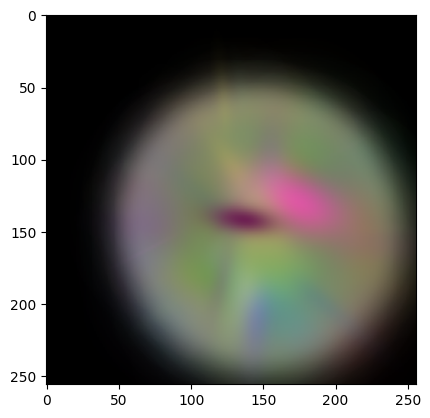

In [47]:
plt.imshow((renders[0].data.numpy() * 255).astype(np.uint8))

In [49]:
import cv2
out = cv2.VideoWriter(
        str("/home/ubuntu/gsplats-expr/outpy.avi"),
        cv2.VideoWriter_fourcc("M", "J", "P", "G"),
        24,
        (width, height),
    )
for r in renders[::10]:
    out.write((r.cpu().data.numpy() * 255).astype(np.uint8)[:, :, ::-1])
out.release()


In [21]:
output.images.shape

torch.Size([4, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.50331205..1.1162591].


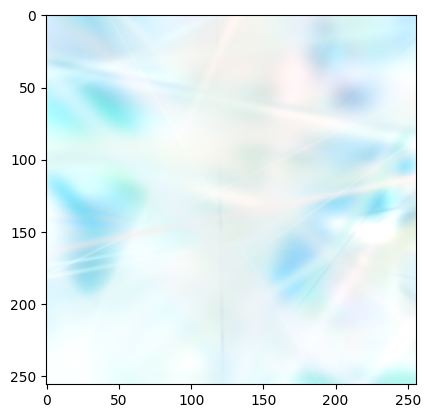

In [24]:
plt.imshow(render_colors[2].cpu().data.numpy())

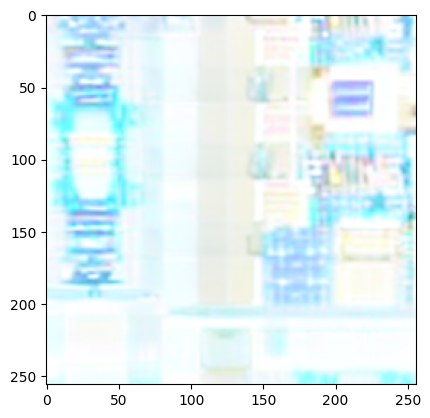

In [23]:

plt.imshow(output.images.permute(0, 2, 3, 1).float()[2].cpu().data.numpy())